In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [160]:
import csv
import pickle
import joblib
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from itertools import combinations
from time import time
from nltk.tokenize import RegexpTokenizer
from collections import OrderedDict
import warnings
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from statistics import mean
from nltk.corpus import wordnet 
import requests
from bs4 import BeautifulSoup
from collections import Counter
import operator
from xgboost import XGBClassifier
import math 
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
stop_words = stopwords.words('english')
from gensim.parsing.preprocessing import remove_stopwords
from decimal import Decimal

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
symptoms_vocab = set() # Stores all unique symptoms
Processed_SympD= OrderedDict() # Key: disease, Value:[List of symptoms]

loading the disease-symptom dictionary that is scraped from the websites

In [17]:
infile = open('/content/drive/MyDrive/full_Dict_IR.pickle','rb')
full_dict = pickle.load(infile)

function to get synonym of the word

In [5]:
def create_Synonym(term):
    mySynonyms = []
    final_Syn = []
    website = 'https://www.synonym.com/synonyms/';
    myLinkFinder = website + term
    synoPage = requests.get(myLinkFinder,verify=False)
    currContent = BeautifulSoup(synoPage.content, 'html5lib')
    html_Div = currContent.find('div', class_='section-list-wrapper show')
    if html_Div != None:
        rows = html_Div.find_all('li')
        if rows!=None:
            for row in rows:
                mySynonyms.append(row.gdrive)

            for currSyn in wordnet.synsets(term):
                mySynonyms+=currSyn.lemma_names()
  
            for idx in mySynonyms:
                if idx == None:
                    continue;
                else :
                    final_Syn.append(idx)

  
    return set(final_Syn)

def extend_symptoms(refined_symptoms):
  extended_symptom=[]
  for sym in refined_symptoms:
  #remove stopwords if any before taking its synonym
    sym=remove_stopwords(sym)
    sym = sym.split()
    set_sym = set()
    for comb in range(1, len(sym)+1):
        for sub_set in combinations(sym, comb):
            sub_set=' '.join(sub_set)
            sub_set = create_Synonym(sub_set) 
            set_sym.update(sub_set)
        set_sym.update(sym)
    extended_symptom.append(' '.join(set_sym))
  #print(extended_symptom)
  return extended_symptom

def getJaccard(setA,setB):
  #print(setA,setB)
  return(len(setA.intersection(setB))/len(setA.union(setB)))

In [ ]:
unique_symptoms=set()
disease_symptom_clean={}

code to clean the symptoms as it has as punctuations, unwanted text etc.

In [ ]:
#cleaning symptoms initially 
for dis in full_dict.keys():
  val = full_dict[dis]
  my_list=val.lower().split(",")
  list_change=[]
  for token in my_list:
    token=token.strip()
    if "(" in token or ")" in token:
      list_change.append(token.split(" ")[0])
    else:
      list_change.append(token)
  
  temp=[]
  for sym in list_change:
    sym=sym.replace('-',' ')
    sym=sym.replace("'",'')
    sym=sym.replace(",",'')
    sym=sym.replace("(",'')
    sym=sym.replace(")",'')
    sym=sym.replace(":",'')
    if sym in stop_words:
      continue
    if len(sym)==0:
      continue
    temp.append(sym)
    unique_symptoms.add(sym)
  disease_symptom_clean[dis]=temp

In [23]:
symptoms_vocab = list(unique_symptoms)
symptoms_vocab.sort()
symptoms_vocab.remove("")

606


adding synonyms to the symptoms

In [ ]:
Symptom_SynDict={}
for symptom in unique_symptoms:
    Symptom_SynDict[symptom]=extend_symptoms(symptom)

saving the symptom-synonym dictionary as pickle file

In [ ]:
pickle.dump(open("Symptom_SynDict",'wb'))

In [19]:
infile = open('/content/drive/MyDrive/Symptom_SynDict (1).pickle','rb')
symptom_synonym = pickle.load(infile)

In [20]:
del symptom_synonym['']

now we are filtering the symptoms if two symptoms has jaccard value greater than 0.65(our threshold) than this means that they are almost same.

In [ ]:
def Symptom_Matching(symptoms_vocab): 
    jac_coeff=getJaccard(symptoms_vocab[i],symptoms_vocab[i+1])
    return jac_coeff
matched_symptom=Symptom_Matching(sorted(unique_symptoms))

taking only the unique symptoms as leaving the duplicate symptoms

In [31]:
new_symptoms = set(unique_symptoms).difference(set(matched_symptom.keys()))

making a list of symptoms to store as columns in dataframe

In [36]:
new_symptoms = list(new_symptoms)
new_symptoms.sort()
final_symptoms=['label_disease']+new_symptoms

creating two different dataframes- 1st represent each row as a disease, 2nd represent multiple rows as a disease,its makes our dataset enriched with different combinations of symptoms

In [101]:
df_final = pd.DataFrame(columns=final_symptoms)
df_final_comb = pd.DataFrame(columns=final_symptoms)

function which returns the final symptoms

In [ ]:
def get_final_values(val,matched_symptom):
  temp=[]
  for symptom in val:
        if symptom not in matched_symptom.keys():
          temp.append(symptom)
        else:
          temp.append(matched_symptom[symptom])
  return temp

dataframe value filling

In [112]:
for key, val in Processed_SympD.items():
    temp = get_final_values(val,matched_symptom)
            
    values = list(set(temp))
    #updated dictionary
    Processed_SympD[key] = values
    
    #creating first dataframe(with combination of symptoms)
    normal = {}
    for i in final_symptoms:
     normal[i]=0
    for sym in values:
        normal[sym] = 1
    normal['label_disease']=key
    df_final = df_final.append(pd.Series(normal), ignore_index=True)

    #creating second dataframe(with combination of symptoms)
    for comb in range(2, 4):
        for subset in combinations(values, comb):
            comb = {}
            for i in final_symptoms:
               comb[i]=0
            for sym in list(subset):
                comb[sym]=1
            comb['label_disease']=key
            df_final_comb = df_final_comb.append(pd.Series(comb), ignore_index=True)

In [136]:
df_final_comb.to_csv("df_final_comb.csv",index=False)
df_final_comb=df_final_comb.fillna(0)

In [137]:
acc_list = []
model_list = []

dataspliting for training and testing

In [124]:
X = df_final_comb.iloc[:, 1:]
Y = df_final_comb.iloc[:, 0:1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10,random_state=1)

naive bayes

In [161]:
model_nb = MultinomialNB()
model_nb = model_nb.fit(x_train, y_train)

pred = model_nb.predict(x_test)
acc = round(Decimal(accuracy_score(y_test, pred) * 100), 2)
acc_list.append(acc)
model_list.append("MNB")
print(f"Accuracy : {acc}%")
joblib.dump(model_nb,"naive_bayes.pickle")

Accuracy : 81.20%


['naive_bayes.pickle']

random forest

In [162]:
model_rf = RandomForestClassifier(n_estimators=10, criterion='entropy')
model_rf = model_rf.fit(x_train, y_train)

pred = model_rf.predict(x_test)
acc = round(Decimal(accuracy_score(y_test, pred) * 100), 2)
acc_list.append(acc)
model_list.append("RF")
print(f"Accuracy : {acc}%")
joblib.dump(model_rf,"random_forest.pickle")

Accuracy : 83.48%


['random_forest.pickle']

KNN

In [163]:
model_knn = KNeighborsClassifier(n_neighbors=7, weights='distance', n_jobs=4)
model_knn = model_knn.fit(x_train, y_train)

pred = model_knn.predict(x_test)
acc = round(Decimal(accuracy_score(y_test, pred) * 100), 2)
acc_list.append(acc)
model_list.append("KNN")
print(f"Accuracy : {acc}%")
joblib.dump(model_knn,"knn.pickle")

Accuracy : 86.99%


['knn.pickle']

Logistic Regression

In [165]:
model_lr = LogisticRegression()
model_lr = model_lr.fit(x_train, y_train)

pred = model_lr.predict(x_test)
acc = round(Decimal(accuracy_score(y_test, pred) * 100), 2)
acc_list.append(acc)
model_list.append("LR")
print(f"Accuracy : {acc}%")
joblib.dump(model_lr,"LR.pickle")

Accuracy : 90.51%


['LR.pickle']

Svm

In [166]:
model_svm = SVC()
model_svm = model_svm.fit(x_train, y_train)

pred = model_svm.predict(x_test)
acc = round(Decimal(accuracy_score(y_test, pred) * 100), 2)
acc_list.append(acc)
model_list.append("SVM")
print(f"Accuracy  : {acc}%")
joblib.dump(model_svm,"svm.pickle")

Accuracy  : 90.16%


['svm.pickle']

Decision Tree

In [167]:
model_dt = DecisionTreeClassifier()
model_dt = model_dt.fit(x_train, y_train)

pred = model_dt.predict(x_test)
acc = round(Decimal(accuracy_score(y_test, pred) * 100), 2)
acc_list.append(acc)
model_list.append("DT")
print(f"Accuracy : {acc}%")
joblib.dump(model_dt,"dt.pickle")

Accuracy : 76.98%


['dt.pickle']

Plotting the graph of model vs accuracy

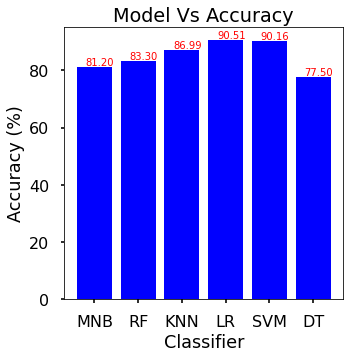

In [157]:
plt.style.use('seaborn-poster')
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
plt.title("Models vs Accuracy")
plt.xlabel('models')
plt.ylabel('Accuracy (%)')
plt.bar(model_list, acc_list, color='blue')
for i, j in enumerate(acc_list):
    ax.text(float(i)-0.20, float(j)+0.7, str(j), color='red')
plt.show()